# Imports

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    ResizeD,
    LoadImage,
    Rotate,
    Randomizable,
    Transform,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR, SwinUNETR, BasicUNet, SegResNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from aim.pytorch import track_gradients_dists, track_params_dists
import torch
import aim
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np

print_config()

MONAI version: 1.4.dev2404
Numpy version: 1.26.3
Pytorch version: 2.2.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 3ebfa1ee9980ae588ac19164d797684069af4c5a
MONAI __file__: /home/<username>/.cache/pypoetry/virtualenvs/monai-train-8zVRO0F8-py3.11/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.

# Loading data and preprocessing

In [3]:
#directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
#print(root_dir)
root_dir = "/home/adnanzai"
data_dir = os.path.join(root_dir, "mice_data_v3")

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]

#train_files, val_files = data_dicts[:-4], data_dicts[-4:]

train_size = int(0.8 * len(data_dicts))
val_size = len(data_dicts) - train_size
train_files, val_files = torch.utils.data.random_split(data_dicts, [train_size, val_size])

In [4]:
for x in train_files:
    print(x)

{'image': '/home/adnanzai/mice_data_v3/imagesTr/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_RH copy 2.nii.gz', 'label': '/home/adnanzai/mice_data_v3/labelsTr/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_RH copy 2.nii.gz'}
{'image': '/home/adnanzai/mice_data_v3/imagesTr/cropped filtered_Piezo2_JR33628_E185_female_experimental_homozygote_b39ed7b3915b9080745cc8df9028b938_RH copy 2.nii.gz', 'label': '/home/adnanzai/mice_data_v3/labelsTr/cropped filtered_Piezo2_JR33628_E185_female_experimental_homozygote_b39ed7b3915b9080745cc8df9028b938_RH copy 2.nii.gz'}
{'image': '/home/adnanzai/mice_data_v3/imagesTr/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_LH.nii.gz', 'label': '/home/adnanzai/mice_data_v3/labelsTr/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_LH.nii.gz'}
{'image': '/home/adnanzai/mice_

In [5]:
set_determinism(seed=0)

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        ResizeD(keys=["image", "label"],spatial_size=(256,256,256)), # Unet
        #ResizeD(keys=["image", "label"],spatial_size=(96, 96, 96)), # Unetr
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            #spatial_size=(256, 256, 256), # Unet
            spatial_size=(48,48,48), # Unet
            #spatial_size=(32, 32, 32), # Swin Unetr
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        ResizeD(keys=["image", "label"],spatial_size=(256,256,256)), #Unet
        #ResizeD(keys=["image", "label"],spatial_size=(96, 96, 96)), # Unetr
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/home/adnanzai/.cache/pypoetry/virtualenvs/monai-train-8zVRO0F8-py3.11/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


image shape: torch.Size([61, 81, 64]), label shape: torch.Size([61, 81, 64])


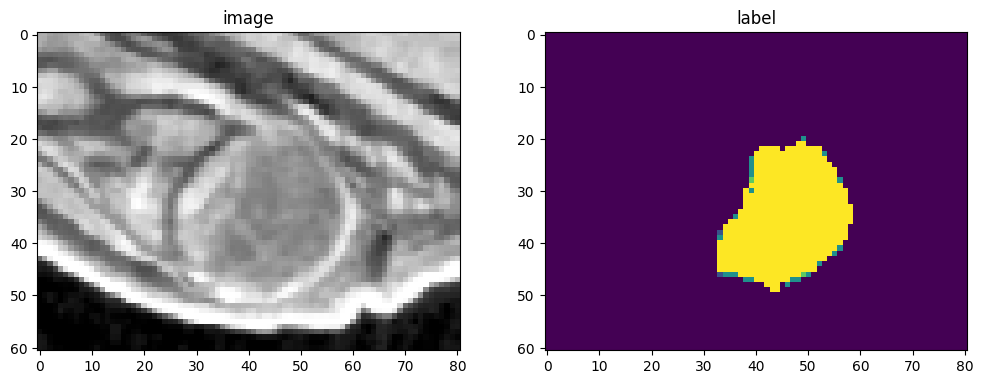

In [7]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 40]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 40], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 40])
plt.show()

In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 7/7 [00:01<00:00,  5.60it/s]


# Unet Model

In [9]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

model_metadata = {
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "channels": (16, 32, 16, 8),
    "strides": (2, 2, 2),
    "num_res_units": 2,
    "norm": "BATCH",
}

model = UNet(**model_metadata).to(device)

model_type = "UNet"
loss_type = "DiceLoss"

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")


Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

# BasicUnet Model

In [194]:
device = torch.device("cuda:0")

model_metadata = {
    "spatial_dims": 3,
    "in_channels": 1,
    "out_channels": 2,
    "features": (32, 32, 64, 64, 64, 32),
    "dropout": 0.1,
}
model = BasicUNet(**model_metadata).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")

model_type = "BasicUNet"
loss_type = "DiceCELoss"

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

BasicUNet features: (32, 32, 64, 64, 64, 32).


# SegResNet

In [198]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegResNet(
            blocks_down=[1, 2, 2, 1],
            blocks_up=[1, 2, 2],
            init_filters=8,
            in_channels=1,
            out_channels=2,
            dropout_prob=0.1,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Unetr

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_metadata = {
    "spatial_dims":3,
    "in_channels":1,
    "out_channels":2,
    "img_size":(48,48,48),
    "feature_size":8,
    "hidden_size":1536,
    "mlp_dim":3072,
    "num_heads":48,
    "pos_embed":"conv",
    "norm_name":"instance",
    "res_block":True,
}


model = UNETR(**model_metadata).to(device)

model_type = "UNetr"
#loss_type = "DiceCELoss"

#loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
#dice_metric = DiceMetric(include_background=False, reduction="mean")

loss_type = "DiceLoss"
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=True, reduction="mean")

Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f"param_group_{ind}"] = {
        key: value for (key, value) in param_group.items() if "params" not in key
    }

/home/adnanzai/project/monai/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.unetr UNETR.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)


# Pytorch training pipeline

In [ ]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (48, 48, 48) # used to be 160
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

In [245]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8748 at epoch: 106


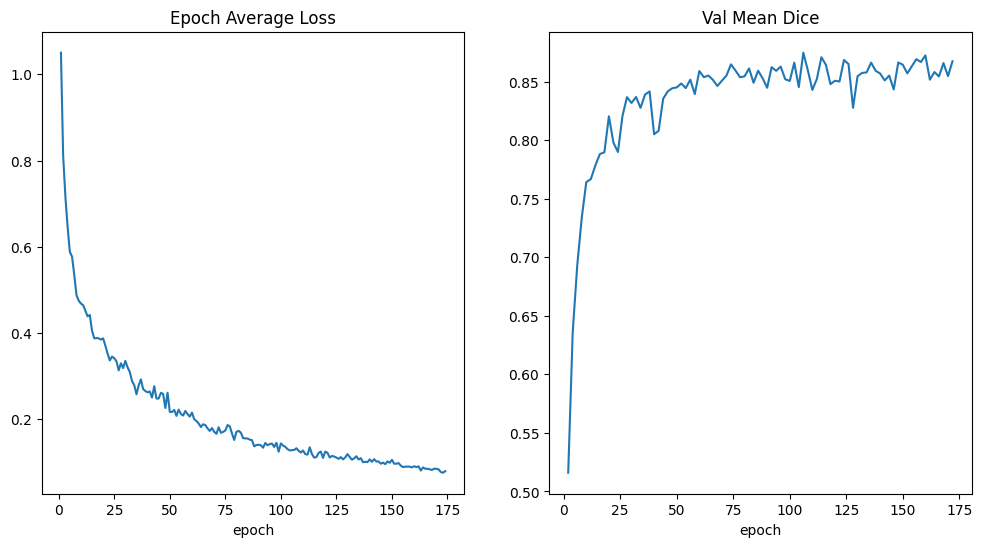

In [246]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Inference 

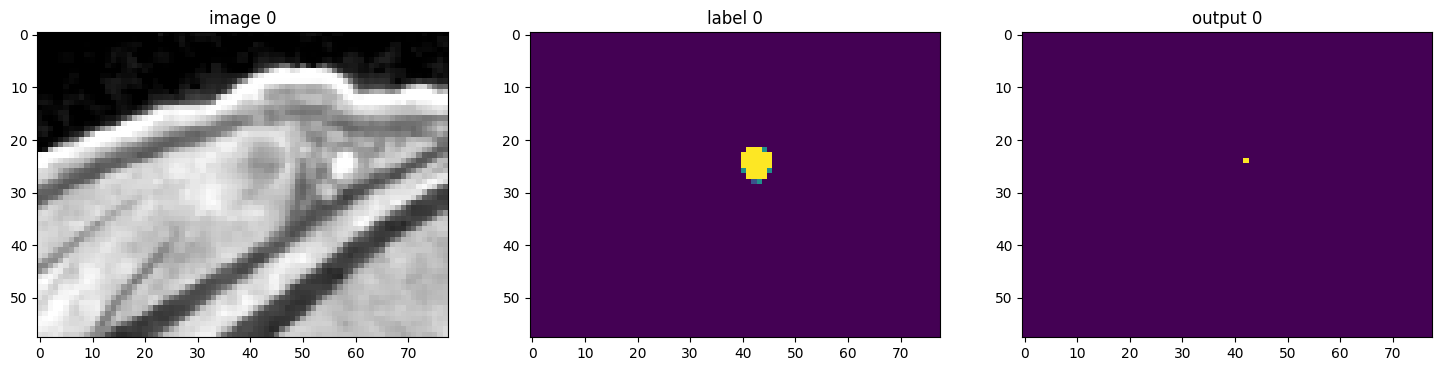

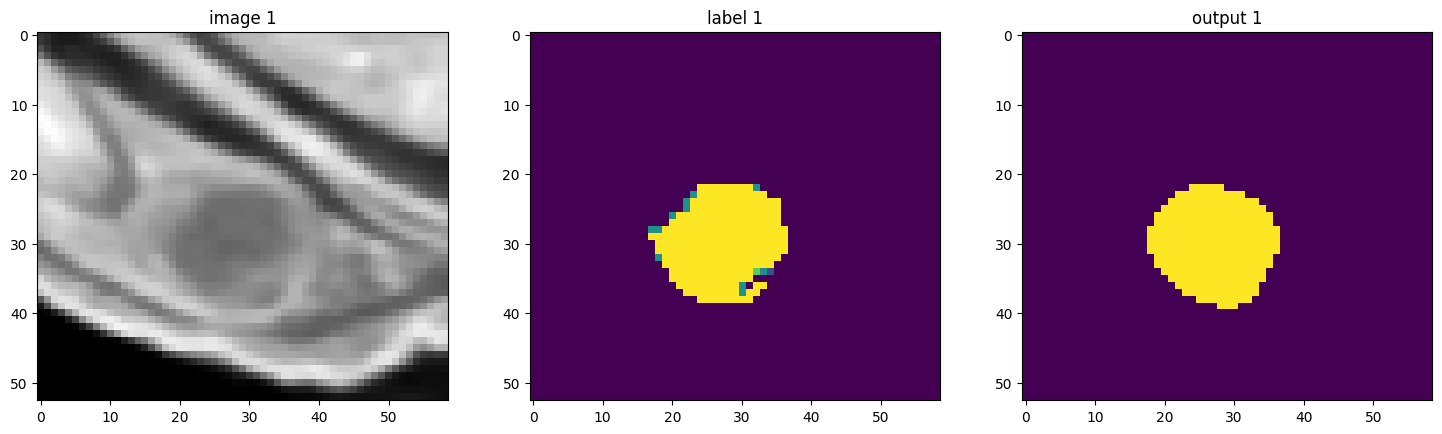

In [12]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (48, 48, 48) # used to be 160
        sw_batch_size = 4
        slice = 12
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, slice]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, slice], cmap="gray")
        
        #mask_pred = np.zeros(val_data["image"][0, 0, :, :, slice].shape)
        #mask_pred[torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice]==1] = 1
        #masked_pred = np.ma.masked_where(mask_pred == 0, mask_pred)
        #plt.imshow(masked_pred, 'Spectral', interpolation='none', alpha=0.7)

        #mask_org = np.zeros(val_data["image"][0, 0, :, :, slice].shape)
        #mask_org[val_data["label"][0, 0, :, :, slice]==1] = 1
        #masked_org = np.ma.masked_where(mask_org == 0, mask_org)
        #plt.imshow(masked_org, 'ocean', interpolation='none', alpha=0.3)

        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, slice])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice])
        plt.show()
        if i == 1:
            break

# Test data inference

In [30]:
test_images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))

test_data = [{"image": image} for image in test_images]


test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

test_org_ds = Dataset(data=test_data, transform=test_org_transforms)

test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [31]:
# # uncomment the following lines to visualize the predicted results
loader = LoadImage()

2024-02-01 13:58:50,303 INFO image_writer.py:197 - writing: out/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_LH/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_LH_seg.nii.gz


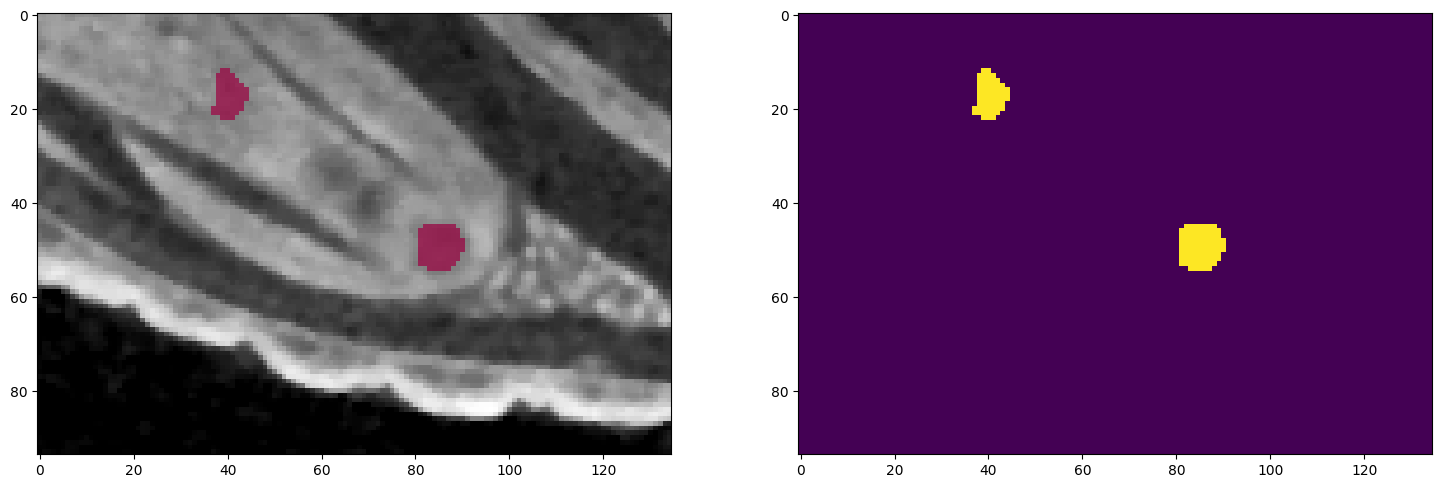

2024-02-01 13:58:50,754 INFO image_writer.py:197 - writing: out/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_RH/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_RH_seg.nii.gz


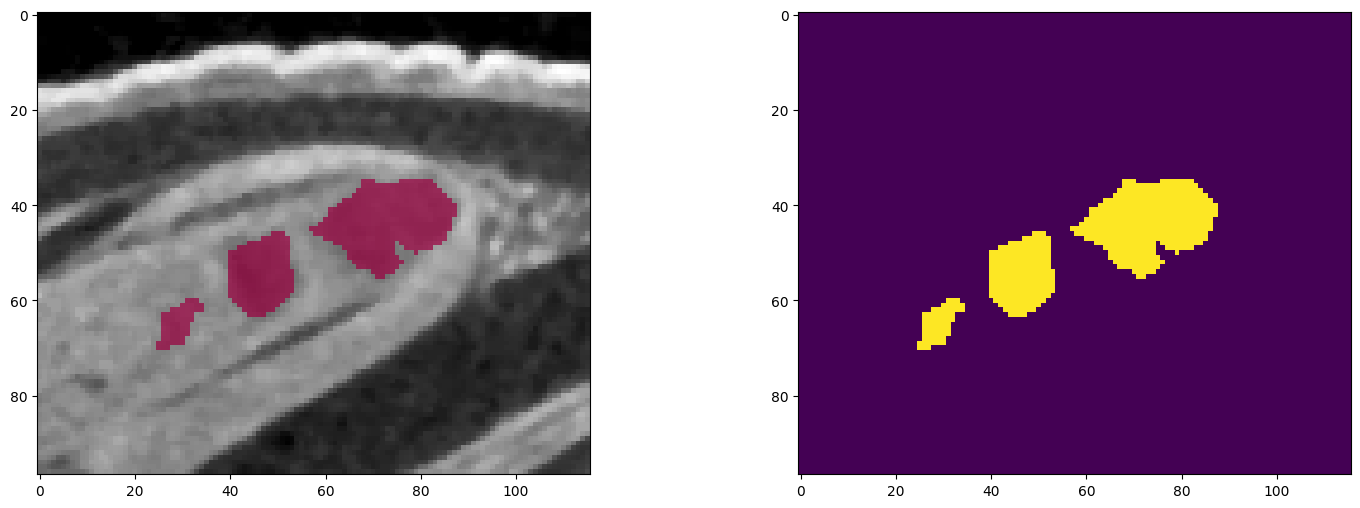

2024-02-01 13:58:51,039 INFO image_writer.py:197 - writing: out/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_LH/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_LH_seg.nii.gz


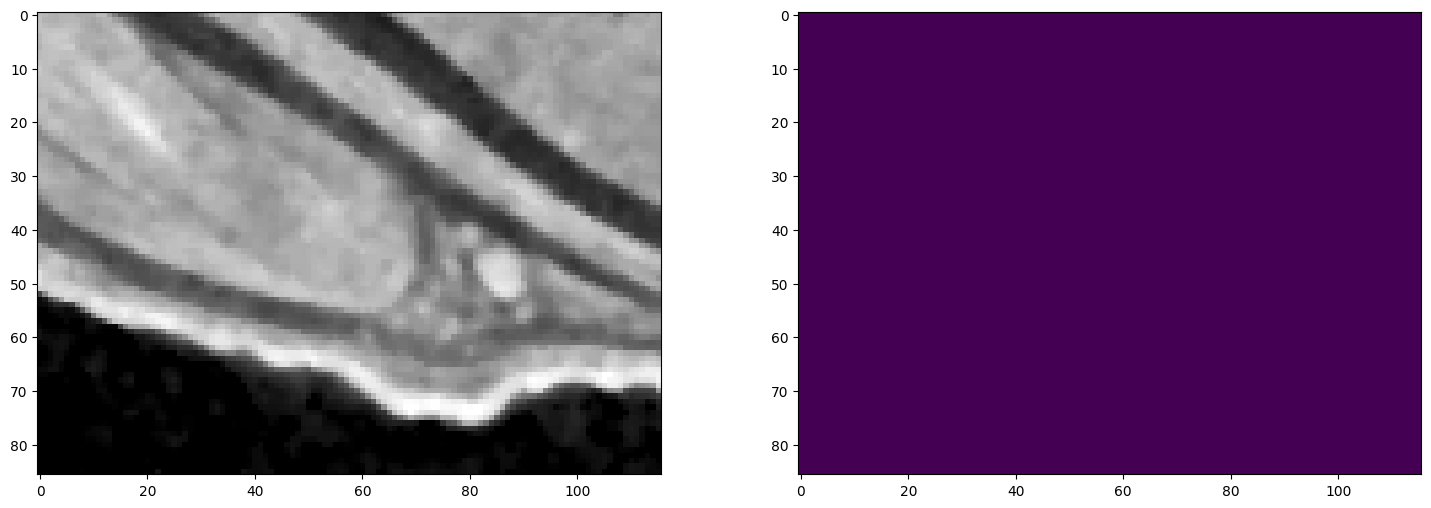

2024-02-01 13:58:51,367 INFO image_writer.py:197 - writing: out/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_RH/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_RH_seg.nii.gz


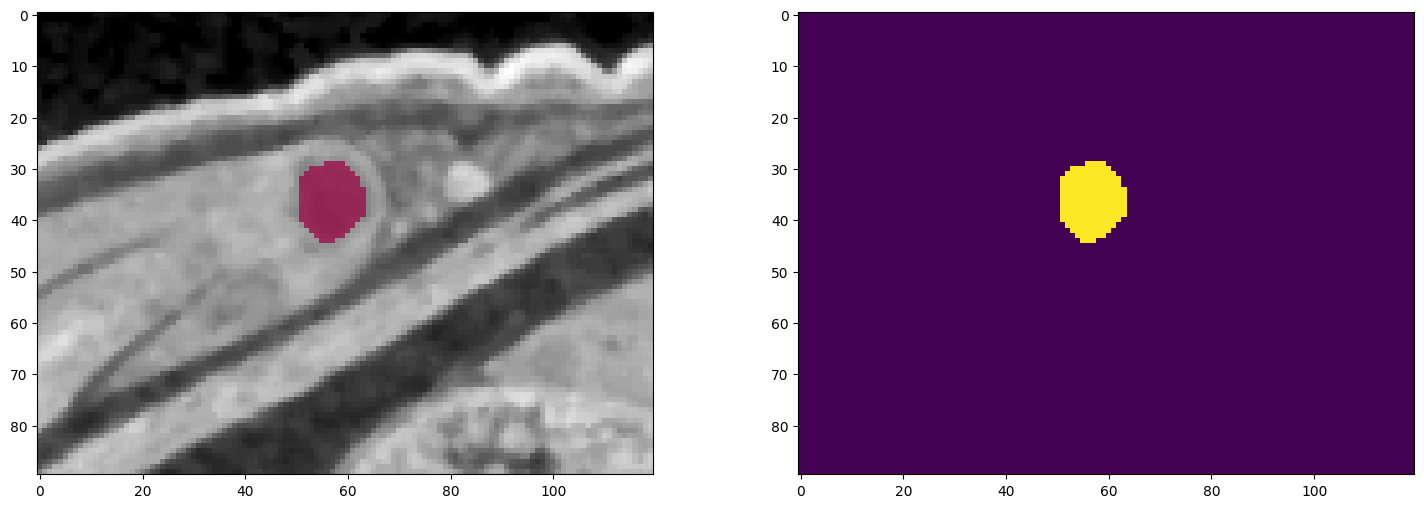

2024-02-01 13:58:51,663 INFO image_writer.py:197 - writing: out/cropped filtered_Odad1_CDOFB_E185_female_control_homozygote_671f6a8121231dfb31e88c4b276d8a13_RH/cropped filtered_Odad1_CDOFB_E185_female_control_homozygote_671f6a8121231dfb31e88c4b276d8a13_RH_seg.nii.gz


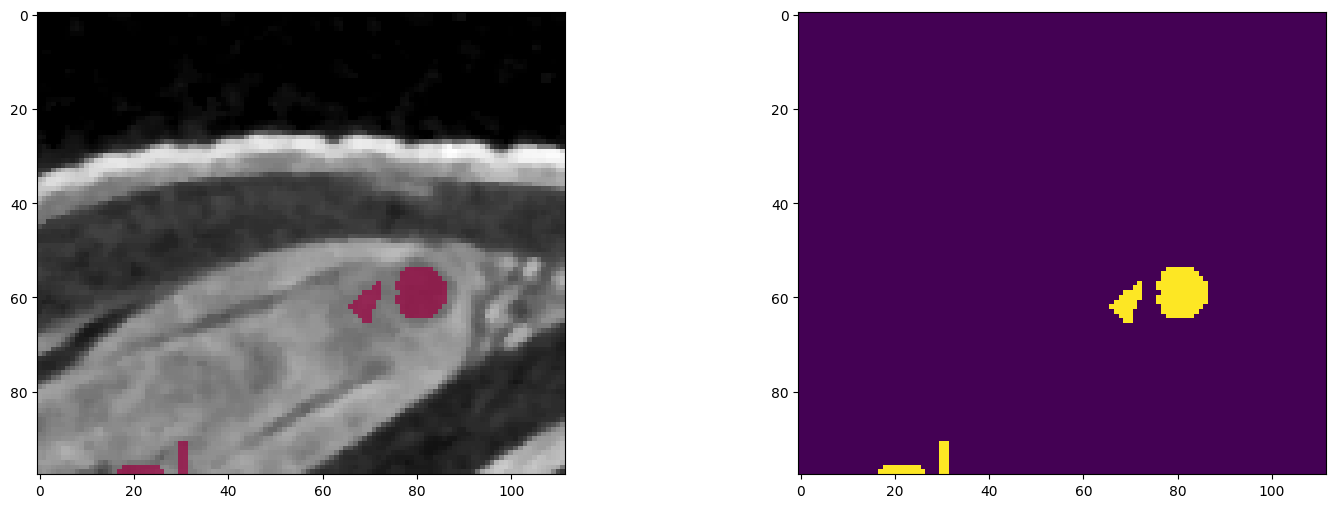

2024-02-01 13:58:51,931 INFO image_writer.py:197 - writing: out/cropped filtered_Patl1_PATTB_E185_male_control_homozygote_26438682f1739e328099bcfb857ac527_RH/cropped filtered_Patl1_PATTB_E185_male_control_homozygote_26438682f1739e328099bcfb857ac527_RH_seg.nii.gz


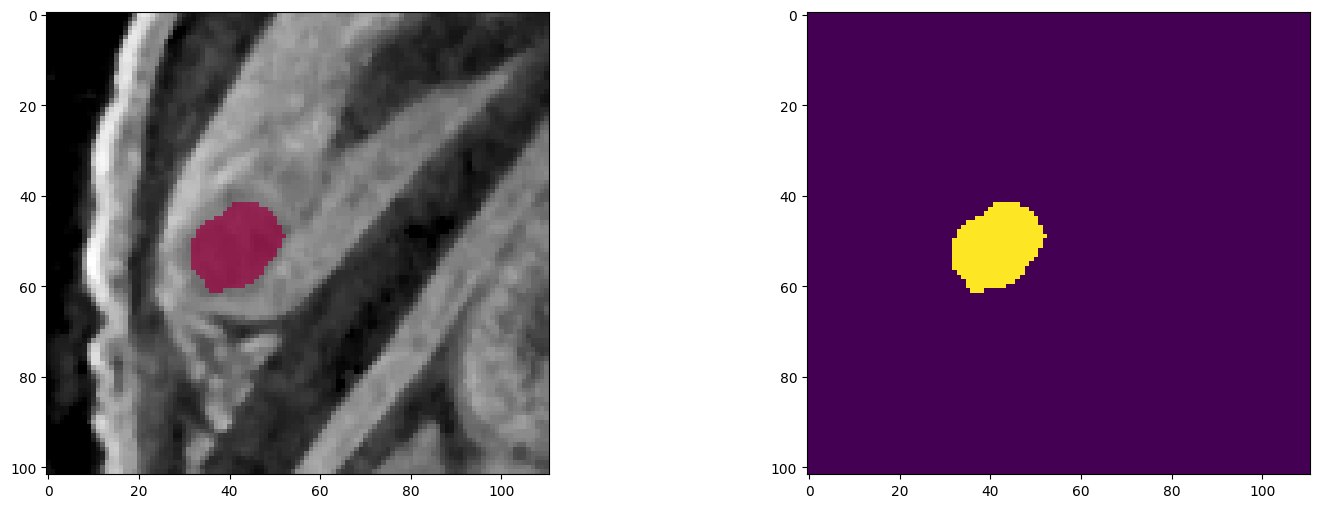

2024-02-01 13:58:52,214 INFO image_writer.py:197 - writing: out/cropped filtered_Piezo2_JR33628_E185_female_experimental_homozygote_b39ed7b3915b9080745cc8df9028b938_RH/cropped filtered_Piezo2_JR33628_E185_female_experimental_homozygote_b39ed7b3915b9080745cc8df9028b938_RH_seg.nii.gz


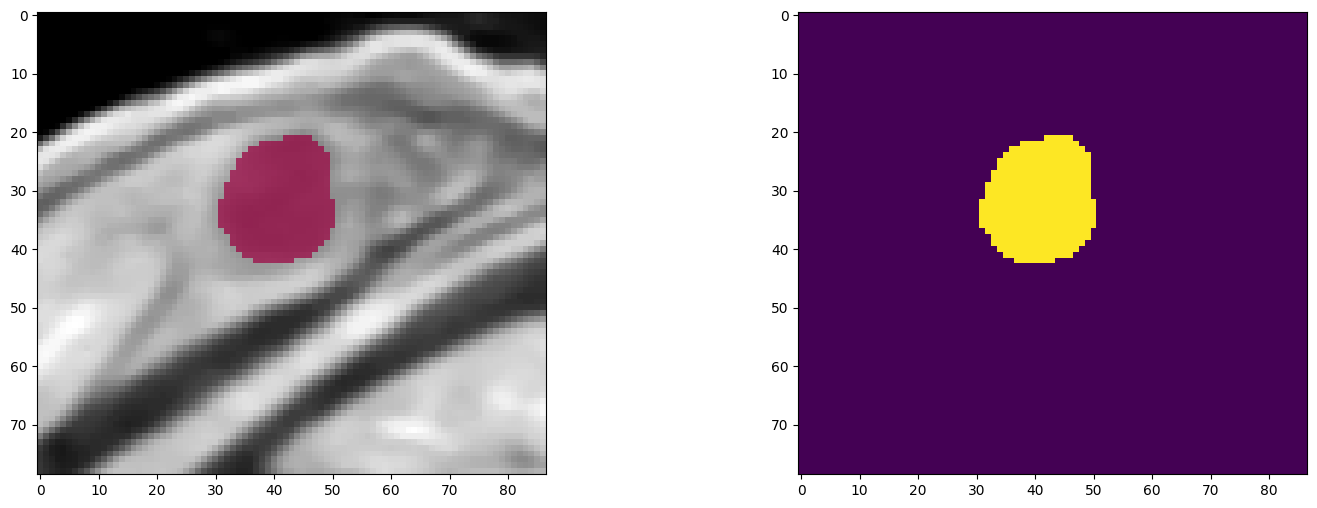

2024-02-01 13:58:52,478 INFO image_writer.py:197 - writing: out/cropped filtered_Zfp414_ZFFFB_E185_female_experimental_homozygote_caa1a267f966579f6dc671d00fe2ab9d_RH/cropped filtered_Zfp414_ZFFFB_E185_female_experimental_homozygote_caa1a267f966579f6dc671d00fe2ab9d_RH_seg.nii.gz


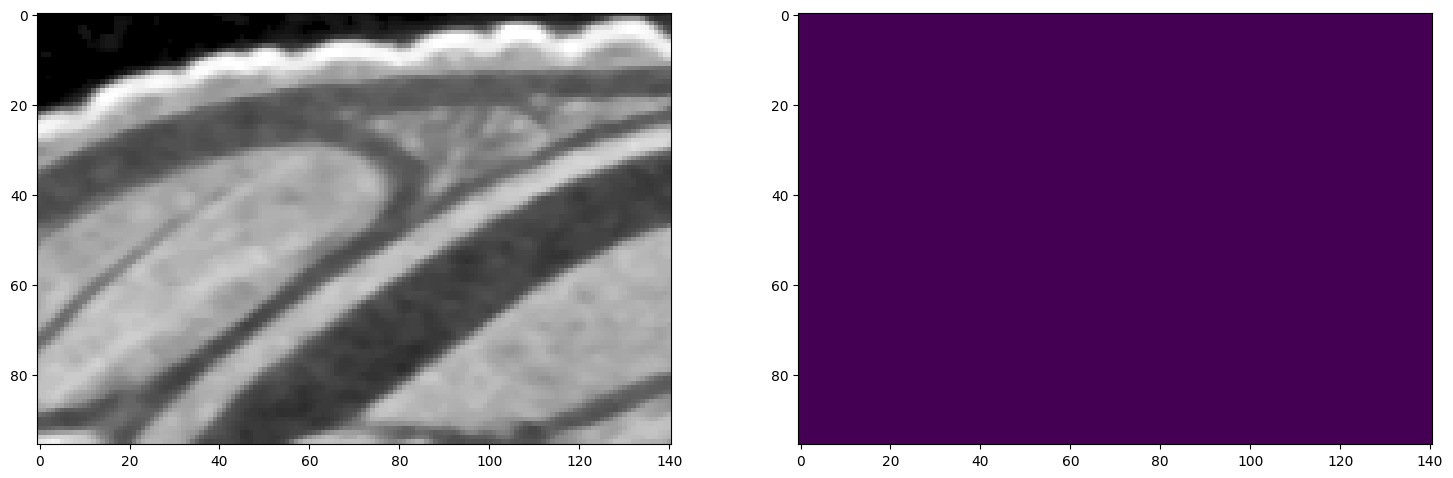

In [35]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = 48 # 160 for UNet, 48 for UNetr
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])
    
        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")

        mask_pred = np.zeros(original_image[:, :, 20].shape)
        mask_pred[test_output[0].detach().cpu()[1, :, :, 20]==1] = 1
        masked_pred = np.ma.masked_where(mask_pred == 0, mask_pred)
        plt.imshow(masked_pred, 'Spectral', interpolation='none', alpha=0.7)
        
        plt.subplot(1, 2, 2)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()

# Aim Pipeline

In [174]:
#!pip install aim
#!pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/a8/07/72953cf70e3bd3a24cbc3e743e6f8539abe6e3e6d83c3c0c83426eaffd39/plotly-5.18.0-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/f4/f1/990741d5bb2487d529d20a433210ffa136a367751e454214013b441c4575/tenacity-8.2.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 50.9 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [10]:
max_epochs = 50
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])


# initialize a new Aim Run
aim_run = aim.Run()
# log model metadata
aim_run["Model_metadata"] = model_metadata
aim_run["Model"] = model_type
# log optimizer metadata
aim_run["Optimizer_metadata"] = Optimizer_metadata

# log max epochs
aim_run["max_epochs"] = max_epochs

slice_to_track = 20

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        # track batch loss metric
        aim_run.track(loss.item(), name="batch_loss", context={"type": loss_type})

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # track epoch loss metric
    aim_run.track(epoch_loss, name="epoch_loss", context={"type": loss_type})

    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        if (epoch + 1) % val_interval * 2 == 0:
            # track model params and gradients
            track_params_dists(model, aim_run)
            # THIS SEGMENT TAKES RELATIVELY LONG (Advise Against it)
            track_gradients_dists(model, aim_run)

        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                aim_run["validation_roi"] = roi_size
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

                # tracking input, label and output images with Aim
                output = torch.argmax(val_outputs, dim=1)[0, :, :, slice_to_track].float()

                aim_run.track(
                    aim.Image(val_inputs[0, 0, :, :, slice_to_track], caption=f"Input Image: {index}"),
                    name="validation",
                    context={"type": "input"},
                )
                aim_run.track(
                    aim.Image(val_labels[0, 0, :, :, slice_to_track], caption=f"Label Image: {index}"),
                    name="validation",
                    context={"type": "label"},
                )
                aim_run.track(
                    aim.Image(output, caption=f"Predicted Label: {index}"),
                    name="predictions",
                    context={"type": "labels"},
                )

                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # track val metric
            aim_run.track(metric, name="val_metric", context={"type": loss_type})

            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))

                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
                aim_run.track(aim.Text(best_model_log_message), name="best_model_log_message", epoch=epoch + 1)
                print(best_model_log_message)

            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"

            aim_run.track(aim.Text(message1 + "\n" + message2 + message3), name="epoch_summary", epoch=epoch + 1)
            print(message1, message2, message3)

def inference_fig():
    model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
    model.eval()
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            roi_size = (48, 48, 48) # used to be 160
            sw_batch_size = 4
            slice = 12
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
            # plot the slice [:, :, slice]
            #fig = plt.figure("check", (18, 6))
            
            fig = plt.figure("check", (18,6))
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][0, 0, :, :, slice], cmap="gray")
            mask_pred = np.zeros(val_data["image"][0, 0, :, :, slice].shape)
            mask_pred[torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice]==1] = 1
            masked_pred = np.ma.masked_where(mask_pred == 0, mask_pred)
            plt.imshow(masked_pred, 'Spectral', interpolation='none', alpha=0.7)
            mask_org = np.zeros(val_data["image"][0, 0, :, :, slice].shape)
            mask_org[val_data["label"][0, 0, :, :, slice]==1] = 1
            masked_org = np.ma.masked_where(mask_org == 0, mask_org)
            plt.imshow(masked_org, 'ocean', interpolation='none', alpha=0.3)
            aim_run.track(aim.Image(fig), name=f"final_{index}")   
            plt.close()
            if i == 1:
                break
    return None

inference_fig()

# finalize Aim Run
aim_run.close()
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

----------
epoch 1/50
1/25, train_loss: 0.5662
2/25, train_loss: 0.5879
3/25, train_loss: 0.5764
4/25, train_loss: 0.5594
5/25, train_loss: 0.5775
6/25, train_loss: 0.5865
7/25, train_loss: 0.5943
8/25, train_loss: 0.5907
9/25, train_loss: 0.5520
10/25, train_loss: 0.5614
11/25, train_loss: 0.5627
12/25, train_loss: 0.5913
13/25, train_loss: 0.5391
14/25, train_loss: 0.5503
15/25, train_loss: 0.5667
16/25, train_loss: 0.5686
17/25, train_loss: 0.5357
18/25, train_loss: 0.5389
19/25, train_loss: 0.5073
20/25, train_loss: 0.5035
21/25, train_loss: 0.5087
22/25, train_loss: 0.5474
23/25, train_loss: 0.5529
24/25, train_loss: 0.4966
25/25, train_loss: 0.5235
epoch 1 average loss: 0.5538
----------
epoch 2/50
1/25, train_loss: 0.4942
2/25, train_loss: 0.5101
3/25, train_loss: 0.4988
4/25, train_loss: 0.5127
5/25, train_loss: 0.5271
6/25, train_loss: 0.5281
7/25, train_loss: 0.5003
8/25, train_loss: 0.4877
9/25, train_loss: 0.4777
10/25, train_loss: 0.4920
11/25, train_loss: 0.4759
12/25, tr

Exception ignored in: <function _after_at_fork_child_reinit_locks at 0x146907ea7ec0>
Traceback (most recent call last):
  File "/sw/pkgs/arc/python/3.11.5/lib/python3.11/logging/__init__.py", line 265, in _after_at_fork_child_reinit_locks
    handler._at_fork_reinit()
  File "/sw/pkgs/arc/python/3.11.5/lib/python3.11/logging/__init__.py", line 920, in _at_fork_reinit
    self.lock._at_fork_reinit()
KeyboardInterrupt: 


KeyboardInterrupt: 

In [11]:
# finalize Aim Run
aim_run.close()
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7296 at epoch: 14


# Extra

In [14]:
$ module load python cuda
$ module load monai-pipeline
$ python monai-pipeline.py --argments --configs 
$ python monai-pipeline.py --diff params

* pytorch/monai GPU training is going to start
* AimStack - all live tracking all hyperparameters, logs, images, training_out, loss, Mean DiceCE
Its Port 43800


SyntaxError: invalid syntax (1095355531.py, line 1)

In [20]:
L = [LoadImaged(keys=["image", "label"]),EnsureChannelFirstd(keys=["image", "label"])]

In [21]:
L

In [22]:
B = Compose(L)

In [23]:
B.transforms

(<monai.transforms.io.dictionary.LoadImaged at 0x1456a1244e50>,
 <monai.transforms.utility.dictionary.EnsureChannelFirstd at 0x1456a1244810>)

In [25]:
type(model_metadata)

dict

In [27]:
model

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
